In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from lightgbm import LGBMClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Carregue aqui o dataset
loans = pd.read_csv(
    '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Data/LOANS.csv')
accounts = pd.read_csv(
    '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Data/ACCOUNTS.csv')
demographics = pd.read_csv(
    '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Data/DEMOGRAPHICS.csv')


In [3]:
join_df = pd.merge(loans, accounts, on='ID')
data = pd.merge(join_df, demographics, on='ID')

In [4]:
def no_checking(x): return 0 if x == 'NO_CHECKING' else x
def existing_savings(x): return 0 if x == 'UNKNOWN' else x

data['CHECKING_BALANCE'] = data['CHECKING_BALANCE'].apply(no_checking)
data['EXISTING_SAVINGS'] = data['EXISTING_SAVINGS'].apply(existing_savings)
data['CHECKING_BALANCE'] = data['CHECKING_BALANCE'].astype(float)
data['EXISTING_SAVINGS'] = data['EXISTING_SAVINGS'].astype(float)


In [128]:
cols = ['ID', 'ALLOW',
        'CURRENT_RESIDENCE_DURATION',
        'EMPLOYMENT_DURATION',
        'INSTALLMENT_PERCENT',
        'EXISTING_CREDITS_COUNT',
        'PAYMENT_TERM',
        'EXISTING_SAVINGS',
        'LOAN_AMOUNT',
        'CHECKING_BALANCE',
        'HOUSING', 'SEX',
        'INSTALLMENT_PLANS', 'JOB_TYPE',
        'LOAN_PURPOSE', 'PROPERTY'
        ]


In [129]:
df = data.drop(data[(data['CHECKING_BALANCE'] >= 1000) | (data['EXISTING_SAVINGS'] >= 3000)].index, axis=0)
print('Foram retiradas {} linhas'.format(data.shape[0] - df.shape[0]))
df = df[cols]

Foram retiradas 252 linhas


In [130]:
data.isna().sum()
df = df.dropna(axis=0)

In [131]:
X = df.drop(['ID', 'ALLOW'], axis=1)
y = df['ALLOW']

test_pct = 0.3  # Separaremos 30% dos dados para testes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_pct, random_state=42)


<AxesSubplot:>

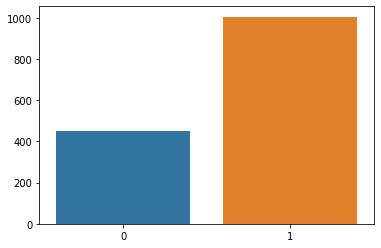

In [132]:
sns.barplot(y_train.value_counts().index, y_train.value_counts().values)

In [133]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1453, 14), (623, 14), (1453,), (623,))

In [134]:
def encoder_ohe(cols_ohe, ohe, X_train, X_val):
    for col in cols_ohe:
        colunas_ohe = ohe.fit_transform(X_train[[col]])
        colunas_ohe_teste = ohe.transform(X_val[[col]])
        
        categorias_ohe = ohe.categories_[0]
        
        for indice, nome_categoria in enumerate(categorias_ohe):
            df_categorias = pd.DataFrame(data=colunas_ohe[:, indice], columns=[nome_categoria])
            df_categorias_teste = pd.DataFrame(data=colunas_ohe_teste[:, indice], columns=[nome_categoria])
            
            
            X_train[nome_categoria] = colunas_ohe[:, indice]
            X_val[nome_categoria] = colunas_ohe_teste[:, indice]
        
    
        X_train = X_train.drop(col, axis=1)
        X_val = X_val.drop(col, axis=1)

    return X_train, X_val

In [135]:
categorical_columns = ['LOAN_PURPOSE', 'PROPERTY',
                       'INSTALLMENT_PLANS', 'SEX', 'HOUSING']
ohe = OneHotEncoder(sparse=False)
X_train, X_val = encoder_ohe(categorical_columns, ohe, X_train, X_val)

In [136]:
from imblearn.over_sampling import SMOTE

In [137]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_sample(X_train, y_train)

In [13]:
# cols_scaler = ['PAYMENT_TERM', 'INSTALLMENT_PERCENT', 'LOAN_AMOUNT', 'CHECKING_BALANCE', 'EXISTING_SAVINGS',
# 'EXISTING_CREDITS_COUNT', 'AGE', 'JOB_TYPE', 'DEPENDENTS', 'EMPLOYMENT_DURATION', 'CURRENT_RESIDENCE_DURATION']
# sc = StandardScaler()
# X_train[cols_scaler] = sc.fit_transform(X_train[cols_scaler])
# X_val[cols_scaler] = sc.transform(X_val[cols_scaler])

# 1 - LGBM

In [147]:
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

model.score(X_val, y_val)


0.7736757624398074

In [ ]:
80,6

In [140]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(model, X_train, y_train, cv=cv).mean()

0.8467661691542288

In [ ]:
84,99

              precision    recall  f1-score   support

           0       0.73      0.59      0.65       223
           1       0.79      0.88      0.83       400

    accuracy                           0.77       623
   macro avg       0.76      0.73      0.74       623
weighted avg       0.77      0.77      0.77       623



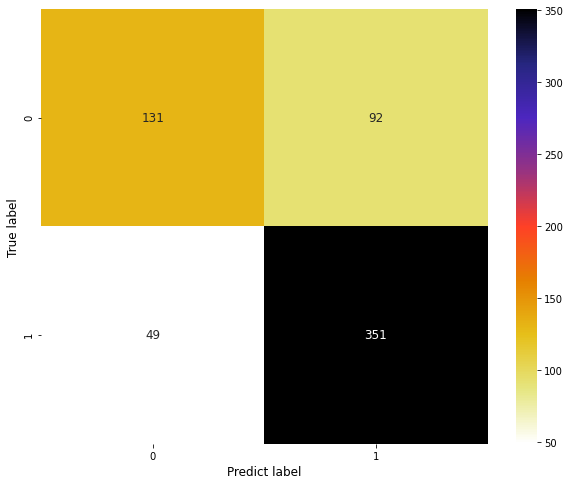

In [141]:
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 12})
plt.xlabel('Predict label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()


## 1.1 - Feature Selection

In [146]:
p = model.predict_proba(X_val)
loss = log_loss(y_val, p)
loss

0.44997118665722513

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss
res = dict()

for col in X_val.columns:
    Xval = X_val.copy()
    Xval[col] = np.random.permutation(Xval[col])

    p = model.predict_proba(Xval)

    ll = log_loss(y_val, p)
    res[col] = ll

    # print(f'Feature: {col}  -  LL Delta: {(loss - ll) * -1 :.4f}')

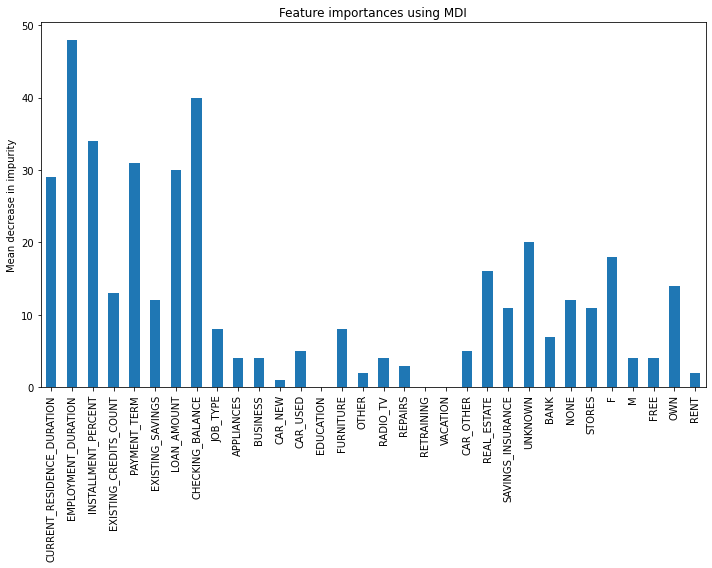

In [143]:
feature_names = model.feature_name_
importances = model.feature_importances_


forest_importances = pd.Series(importances, index=feature_names) 

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [144]:
forest_importances.sort_values(ascending=False)

EMPLOYMENT_DURATION           48
CHECKING_BALANCE              40
INSTALLMENT_PERCENT           34
PAYMENT_TERM                  31
LOAN_AMOUNT                   30
CURRENT_RESIDENCE_DURATION    29
UNKNOWN                       20
F                             18
REAL_ESTATE                   16
OWN                           14
EXISTING_CREDITS_COUNT        13
EXISTING_SAVINGS              12
NONE                          12
SAVINGS_INSURANCE             11
STORES                        11
JOB_TYPE                       8
FURNITURE                      8
BANK                           7
CAR_USED                       5
CAR_OTHER                      5
FREE                           4
M                              4
RADIO_TV                       4
BUSINESS                       4
APPLIANCES                     4
REPAIRS                        3
OTHER                          2
RENT                           2
CAR_NEW                        1
VACATION                       0
RETRAINING

In [145]:
print((loss - pd.Series(res)).sort_values() * -1)

CURRENT_RESIDENCE_DURATION    0.0398
EMPLOYMENT_DURATION           0.0321
REAL_ESTATE                   0.0312
UNKNOWN                       0.0159
F                             0.0150
INSTALLMENT_PERCENT           0.0128
BANK                          0.0100
EXISTING_CREDITS_COUNT        0.0096
PAYMENT_TERM                  0.0094
OUTSTANDING_CREDIT            0.0074
SAVINGS_INSURANCE             0.0073
CAR_OTHER                     0.0056
OTHER                         0.0054
EXISTING_SAVINGS              0.0054
CAR_USED                      0.0054
REPAIRS                       0.0052
BUSINESS                      0.0051
M                             0.0050
APPLIANCES                    0.0047
JOB_TYPE                      0.0047
OWN                           0.0047
FREE                          0.0041
DEPENDENTS                    0.0039
CAR_NEW                       0.0039
PRIOR_PAYMENTS_DELAYED        0.0039
FOREIGN_WORKER                0.0039
ALL_CREDITS_PAID_BACK         0.0039
V

# 2 - Deep Learning

In [17]:
def FeedForward():
    model = Sequential()
    model.add(Dense(units=6, activation='relu', input_dim=43))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [21]:
# model = KerasClassifier(FeedForward, epochs=100, batch_size=10, verbose=0)

# model.fit(X_train, y_train)

In [19]:
pred = model.predict(X_val)
pred = (pred > 0.5)

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6274    0.6683    0.6472       199
           1     0.8312    0.8045    0.8176       404

    accuracy                         0.7595       603
   macro avg     0.7293    0.7364    0.7324       603
weighted avg     0.7639    0.7595    0.7614       603



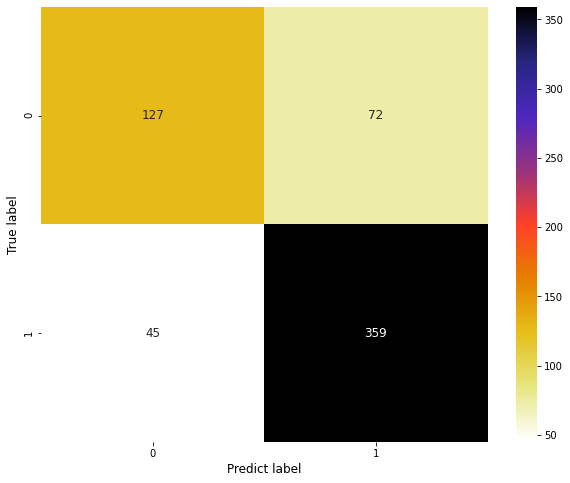

In [20]:
print("Relatório de Classificação:\n", classification_report(y_val, pred, digits=4))
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 12})
plt.xlabel('Predict label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()
